In [1]:
#This script analyzes KO-seq in vitro screens, then later incorporates mouse data that had been previously processed

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(cowplot)
library(gridExtra)
library(extrafont)
library(stats)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘cowplot’ was built under R version 4.3.3”
Warning message:
“package ‘gridExtra’ was built under R version 4.3.3”

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Registering fonts with R



In [3]:
font_import(pattern = 'Arial')

Importing fonts may take a few minutes, depending on the number of fonts and the speed of the system.
Continue? [y/n]  y


Scanning ttf files in /usr/share/fonts/, /usr/local/share/fonts/ ...

Extracting .afm files from .ttf files...

/usr/share/fonts/truetype/msttcorefonts/Arial_Black.ttf
 : Arial-Black already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Bold_Italic.ttf
 : Arial-BoldItalicMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Bold.ttf
 : Arial-BoldMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Italic.ttf
 : Arial-ItalicMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial.ttf
 : ArialMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial.ttf
 : ArialMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Bold.ttf
 : Arial-BoldMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Bold_

In [4]:
#Import files

#.csv files containing upstream and downstream KO-seq read counts
my_directory <- './PhenotypicMap_csvs/'
my_files <- list.files(my_directory, pattern = '*_dedup_counts.csv')

#Dataframe of KO's in deletion library with corresponding plate numbers and QC information
KO_list <- read.csv('./KO_Plate_QC_List.csv', header = TRUE)

#Dataframe of experimental conditions and their paired controls
Comparison_df <- read.csv('./InVitro_Comparisons.csv', header = TRUE)

#Dataframe containing sample metadata, to be used for DESeq2 analysis
sample_data_df <- read.csv('./InVitro_SampleData.csv', header = TRUE)

#Dataframe containing information for C. neoformans H99 protein-coding genes, from FungiDB66
gene_info_df <- read.csv('./GeneInfo_FungiDB66.csv', header = TRUE)

#Dataframe containing processed KO-seq mouse data
mouse_data_df <- read.csv('./KOLibrary_MouseScreen_Primary.csv', header = TRUE)

In [5]:
#Mutants in KO collection later found to be diploid
diploid_set <- c('CNAG_01883', 'CNAG_00039', 'CNAG_01040', 'CNAG_00106', 'CNAG_00394', 'CNAG_04186', 'CNAG_04524', 'CNAG_03114',
                 'CNAG_07380', 'CNAG_02335', 'CNAG_03227', 'CNAG_03308', 'CNAG_01175', 'CNAG_02655', 'CNAG_02473', 'CNAG_03965',
                 'CNAG_03452', 'CNAG_00110', 'CNAG_00542', 'CNAG_01658', 'CNAG_03171', 'CNAG_04241', 'CNAG_05971', 'CNAG_06027')

In [6]:
#Pull out relevant columns from gene_info_df
gene_info_df <- gene_info_df %>% rename(Gene = Gene.ID, GeneName = Gene.Name.or.Symbol, ProductDescription = Product.Description) %>%
    select(Gene, GeneName, ProductDescription)

In [7]:
#Set up empty dataframe to contain upstream and downstream KO-seq counts for each mutant
my_df <- data.frame(Gene = factor(),
                    Experiment = factor(),
                    Condition = factor(),
                    Replicate = factor(),
                    UpCount = integer(),
                    DownCount = integer())

In [8]:
#Script below parses KO-seq .csv files, pulls relevant metadata and read counts, and writes everything to my_df
#Note that .csv files had been renamed to a standardized format that is necessary for the script below to parse
#Relevant fields in filenames are separate by underscores and are:
#Experiment_ConditionInfo1_ConditionInfo2_Replicate_SequencingRun_KOseqJunction_[RemainderIrrelevant]
#Sequencing run in filename should contain "MBHM" followed by a 2-digit number for script below to run

#Iterate through .csv files
for(file_name1 in my_files){

    #Start with files for downstream KO-seq counts
    if(grepl('_Down_', file_name1)){

        #Pull experiment, condition, and replicate from file name fields 1, 2+3, and 4
        experiment <- strsplit(file_name1, '_')[[1]][[1]]
        condition <- paste(strsplit(file_name1, '_')[[1]][[2]], strsplit(file_name1, '_')[[1]][[3]], sep = '_')
        replicate <- strsplit(file_name1, '_')[[1]][[4]]

        #Make general sample name from everything that comes before SequencingRun (designated by "MBHM")
        sample_name <- paste(strsplit(strsplit(file_name1, '_MBHM')[[1]][[1]], '_')[[1]], collapse = '_')

        #Find file with corresponding upstream KO-seq counts
        for(file_name2 in my_files){
            if(grepl('_Up_', file_name2) & paste(strsplit(strsplit(file_name2, '_MBHM')[[1]][[1]], '_')[[1]], collapse = '_') == sample_name){
                
                #Create dataframes containing downstream or upstream counts for each mutant
                down_df <- read.csv(paste(my_directory, file_name1, sep = ''), header = TRUE) %>% select(c('Gene', 'Count')) %>% rename(DownCount = Count)
                up_df <- read.csv(paste(my_directory, file_name2, sep = ''), header = TRUE) %>% select(c('Gene', 'Count')) %>% rename(UpCount = Count)
                
                #Merge downstream and upstream dfs, pull in KO data from KO_list, rename and reorganize columns,
                #convert NA counts to 0, merge in FungiDB gene info, add all rows to my_df
                merged_df <- merge(down_df, up_df, by = 'Gene', all = TRUE)
                merged_df <- merge(merged_df, KO_list, by = 'Gene', all.y = TRUE)
                merged_df <- mutate(merged_df,
                                    Experiment = factor(experiment),
                                    Condition = factor(condition),
                                    Replicate = factor(replicate)) %>% 
                            select(Gene, Plate, QC, Experiment, Condition, Replicate, UpCount, DownCount)
                merged_df[is.na(merged_df)] <- as.double(0)
                merged_df <- merge(merged_df, gene_info_df, by = 'Gene', all.x = TRUE)
                my_df <- rbind(my_df, merged_df)
            }
        }
    }
}

In [9]:
#Filter out genes that aren't in current genome annotation, that failed QC, or that are likely diploids
my_df <- my_df %>% filter(Gene %in% gene_info_df$Gene, !(QC == "Fail"), !(Gene %in% diploid_set))

In [10]:
#Sum upstream and downstream counts for each mutant, create "Sample" name
my_df <- my_df %>% mutate(SummedCounts = UpCount + DownCount)
my_df <- my_df %>% mutate(Sample = paste(Experiment, Condition, sep = '_'))
my_df <- my_df %>% mutate(Sample = paste(Sample, Replicate, sep = '_'))

In [11]:
#Calculate normalized counts and log2 normalized counts for each replicate for the purpose of assessing replicate reproducibility

my_df <- my_df %>% group_by(Experiment, Condition, Replicate) %>% mutate(NormalizedCounts = ((SummedCounts/sum(SummedCounts))*1000000) + 1,
                                               log2NormCounts = log2(NormalizedCounts)) %>%
ungroup()

In [12]:
#Average replicate log2 normalized counts to compare treated samples vs control untreated on scatterplots

my_df <- my_df %>% group_by(Gene, Experiment, Condition) %>% mutate(Avg_log2NormCounts = mean(log2NormCounts)) %>% ungroup()

In [13]:
#Pivot per-replicate log2 norm counts and average log2 norm counts to wider dataframes for plotting purposes

log2norm_counts_df <- my_df %>% select(Gene, GeneName, ProductDescription, Sample, log2NormCounts) %>%
        pivot_wider(names_from = Sample, values_from = log2NormCounts)

Avg_log2norm_counts_df <- my_df %>% filter(Replicate == '1') %>% select(Gene, GeneName, ProductDescription, Sample, Avg_log2NormCounts) %>%
        pivot_wider(names_from = Sample, values_from = Avg_log2NormCounts)

In [14]:
#Start reorganizing dataframe for DESeq2

#First remove input controls since I don't need them for this analysis; create dataframe containing Genes and count data with experiments as columns
counts_df <- my_df %>% filter(!(Condition %in% c('Input_Ctrl'))) %>% select(Gene, GeneName, ProductDescription, Sample, SummedCounts) %>%
    pivot_wider(names_from = Sample, values_from = SummedCounts)

In [15]:
#Remove mutants that had 0 read counts in any of my samples
counts_df <- counts_df %>% filter(rowSums(select(., -Gene, -GeneName, -ProductDescription)) > 0)

In [16]:
#Assign sample name to be row name in sampe_data_df
row.names(sample_data_df) <- sample_data_df$sampleName

#Make genes the row names in counts_df
counts_df <- as.data.frame(counts_df)
row.names(counts_df) <- counts_df$Gene
counts_df <- subset(counts_df, select = -c(Gene, GeneName, ProductDescription))
counts_df <- counts_df[, rownames(sample_data_df)]

In [17]:
library('DESeq2')

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:tidyr’:

    expand


The following objects are masked from ‘

In [18]:
#Prep sample data for each experiment separately

Exp1_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp1')
Exp2_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp2')
Exp3_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp3')
Exp4_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp4')
Exp5_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp5')
Exp6_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp6')
Exp7_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp7')
Exp8_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp8')
Exp9_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp9')
Exp10_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp10')
Exp11_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp11')
Exp12_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp12')
Exp13_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp13')
Exp14_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp14')
Exp15_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp15')
Exp16_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp16')
Exp17_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp17')
Exp18_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp18')
Exp19_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp19')
Exp20_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp20')
Exp21_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp21')
Exp22_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp22')
Exp23_sample_data_df <- sample_data_df %>% filter(Experiment == 'Exp23')

In [19]:
#Prep counts for each experiment separately

Exp1_counts_df <- counts_df[, c(Exp1_sample_data_df$sampleName)]
Exp2_counts_df <- counts_df[, c(Exp2_sample_data_df$sampleName)]
Exp3_counts_df <- counts_df[, c(Exp3_sample_data_df$sampleName)]
Exp4_counts_df <- counts_df[, c(Exp4_sample_data_df$sampleName)]
Exp5_counts_df <- counts_df[, c(Exp5_sample_data_df$sampleName)]
Exp6_counts_df <- counts_df[, c(Exp6_sample_data_df$sampleName)]
Exp7_counts_df <- counts_df[, c(Exp7_sample_data_df$sampleName)]
Exp8_counts_df <- counts_df[, c(Exp8_sample_data_df$sampleName)]
Exp9_counts_df <- counts_df[, c(Exp9_sample_data_df$sampleName)]
Exp10_counts_df <- counts_df[, c(Exp10_sample_data_df$sampleName)]
Exp11_counts_df <- counts_df[, c(Exp11_sample_data_df$sampleName)]
Exp12_counts_df <- counts_df[, c(Exp12_sample_data_df$sampleName)]
Exp13_counts_df <- counts_df[, c(Exp13_sample_data_df$sampleName)]
Exp14_counts_df <- counts_df[, c(Exp14_sample_data_df$sampleName)]
Exp15_counts_df <- counts_df[, c(Exp15_sample_data_df$sampleName)]
Exp16_counts_df <- counts_df[, c(Exp16_sample_data_df$sampleName)]
Exp17_counts_df <- counts_df[, c(Exp17_sample_data_df$sampleName)]
Exp18_counts_df <- counts_df[, c(Exp18_sample_data_df$sampleName)]
Exp19_counts_df <- counts_df[, c(Exp19_sample_data_df$sampleName)]
Exp20_counts_df <- counts_df[, c(Exp20_sample_data_df$sampleName)]
Exp21_counts_df <- counts_df[, c(Exp21_sample_data_df$sampleName)]
Exp22_counts_df <- counts_df[, c(Exp22_sample_data_df$sampleName)]
Exp23_counts_df <- counts_df[, c(Exp23_sample_data_df$sampleName)]

In [20]:
#Make separate DESeq datasets for each experiment

Exp1_dds <- DESeqDataSetFromMatrix(countData = Exp1_counts_df,
                                  colData = Exp1_sample_data_df,
                                  design = ~ Condition)

Exp2_dds <- DESeqDataSetFromMatrix(countData = Exp2_counts_df,
                                  colData = Exp2_sample_data_df,
                                  design = ~ Condition)

Exp3_dds <- DESeqDataSetFromMatrix(countData = Exp3_counts_df,
                                  colData = Exp3_sample_data_df,
                                  design = ~ Condition)

Exp4_dds <- DESeqDataSetFromMatrix(countData = Exp4_counts_df,
                                  colData = Exp4_sample_data_df,
                                  design = ~ Condition)

Exp5_dds <- DESeqDataSetFromMatrix(countData = Exp5_counts_df,
                                  colData = Exp5_sample_data_df,
                                  design = ~ Condition)

Exp6_dds <- DESeqDataSetFromMatrix(countData = Exp6_counts_df,
                                  colData = Exp6_sample_data_df,
                                  design = ~ Condition)

Exp7_dds <- DESeqDataSetFromMatrix(countData = Exp7_counts_df,
                                  colData = Exp7_sample_data_df,
                                  design = ~ Condition)

Exp8_dds <- DESeqDataSetFromMatrix(countData = Exp8_counts_df,
                                  colData = Exp8_sample_data_df,
                                  design = ~ Condition)

Exp9_dds <- DESeqDataSetFromMatrix(countData = Exp9_counts_df,
                                  colData = Exp9_sample_data_df,
                                  design = ~ Condition)

Exp10_dds <- DESeqDataSetFromMatrix(countData = Exp10_counts_df,
                                  colData = Exp10_sample_data_df,
                                  design = ~ Condition)

Exp11_dds <- DESeqDataSetFromMatrix(countData = Exp11_counts_df,
                                  colData = Exp11_sample_data_df,
                                  design = ~ Condition)

Exp12_dds <- DESeqDataSetFromMatrix(countData = Exp12_counts_df,
                                  colData = Exp12_sample_data_df,
                                  design = ~ Condition)

Exp13_dds <- DESeqDataSetFromMatrix(countData = Exp13_counts_df,
                                  colData = Exp13_sample_data_df,
                                  design = ~ Condition)

Exp14_dds <- DESeqDataSetFromMatrix(countData = Exp14_counts_df,
                                  colData = Exp14_sample_data_df,
                                  design = ~ Condition)

Exp15_dds <- DESeqDataSetFromMatrix(countData = Exp15_counts_df,
                                  colData = Exp15_sample_data_df,
                                  design = ~ Condition)

Exp16_dds <- DESeqDataSetFromMatrix(countData = Exp16_counts_df,
                                  colData = Exp16_sample_data_df,
                                  design = ~ Condition)

Exp17_dds <- DESeqDataSetFromMatrix(countData = Exp17_counts_df,
                                  colData = Exp17_sample_data_df,
                                  design = ~ Condition)

Exp18_dds <- DESeqDataSetFromMatrix(countData = Exp18_counts_df,
                                  colData = Exp18_sample_data_df,
                                  design = ~ Condition)

Exp19_dds <- DESeqDataSetFromMatrix(countData = Exp19_counts_df,
                                  colData = Exp19_sample_data_df,
                                  design = ~ Condition)

Exp20_dds <- DESeqDataSetFromMatrix(countData = Exp20_counts_df,
                                  colData = Exp20_sample_data_df,
                                  design = ~ Condition)

Exp21_dds <- DESeqDataSetFromMatrix(countData = Exp21_counts_df,
                                  colData = Exp21_sample_data_df,
                                  design = ~ Condition)

Exp22_dds <- DESeqDataSetFromMatrix(countData = Exp22_counts_df,
                                  colData = Exp22_sample_data_df,
                                  design = ~ Condition)

Exp23_dds <- DESeqDataSetFromMatrix(countData = Exp23_counts_df,
                                  colData = Exp23_sample_data_df,
                                  design = ~ Condition)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design for

In [21]:
#Perform separate DESeq2 analyses for each experiment

Exp1_dds <- DESeq(Exp1_dds, fitType = 'local')
Exp2_dds <- DESeq(Exp2_dds, fitType = 'local')
Exp3_dds <- DESeq(Exp3_dds, fitType = 'local')
Exp4_dds <- DESeq(Exp4_dds, fitType = 'local')
Exp5_dds <- DESeq(Exp5_dds, fitType = 'local')
Exp6_dds <- DESeq(Exp6_dds, fitType = 'local')
Exp7_dds <- DESeq(Exp7_dds, fitType = 'local')
Exp8_dds <- DESeq(Exp8_dds, fitType = 'local')
Exp9_dds <- DESeq(Exp9_dds, fitType = 'local')
Exp10_dds <- DESeq(Exp10_dds, fitType = 'local')
Exp11_dds <- DESeq(Exp11_dds, fitType = 'local')
Exp12_dds <- DESeq(Exp12_dds, fitType = 'local')
Exp13_dds <- DESeq(Exp13_dds, fitType = 'local')
Exp14_dds <- DESeq(Exp14_dds, fitType = 'local')
Exp15_dds <- DESeq(Exp15_dds, fitType = 'local')
Exp16_dds <- DESeq(Exp16_dds, fitType = 'local')
Exp17_dds <- DESeq(Exp17_dds, fitType = 'local')
Exp18_dds <- DESeq(Exp18_dds, fitType = 'local')
Exp19_dds <- DESeq(Exp19_dds, fitType = 'local')
Exp20_dds <- DESeq(Exp20_dds, fitType = 'local')
Exp21_dds <- DESeq(Exp21_dds, fitType = 'local')
Exp22_dds <- DESeq(Exp22_dds, fitType = 'local')
Exp23_dds <- DESeq(Exp23_dds, fitType = 'local')

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

esti

In [22]:
#Assign results for each comparison in Comparison_df to a variable
for(i in 1:nrow(Comparison_df)){
    Exp <- strsplit(Comparison_df$Comparison[i], '_')[[1]][[1]]    
    Name <- paste0(strsplit(Comparison_df$Comparison[i], '_L2FC')[[1]][[1]], '_res')
    ExperimentalCondition <- Comparison_df$ExperimentalCondition[i]
    ControlCondition <- Comparison_df$ControlCondition[i]    
    assign(Name, results(get(paste0(Exp, '_dds')), contrast = c('Condition', ExperimentalCondition, ControlCondition)))
}

In [23]:
#Shrink L2FC values using ashr lfcShrink function
for(i in 1:nrow(Comparison_df)){
    Exp <- strsplit(Comparison_df$Comparison[i], '_')[[1]][[1]]
    Name <- paste0(strsplit(Comparison_df$Comparison[i], '_L2FC')[[1]][[1]], '_ashrshrink_res')    
    ExperimentalCondition <- Comparison_df$ExperimentalCondition[i]    
    ControlCondition <- Comparison_df$ControlCondition[i]
    assign(Name, lfcShrink(get(paste0(Exp, '_dds')), contrast = c('Condition', ExperimentalCondition, ControlCondition), type = 'ashr'))
}

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/

In [24]:
#Convert ashr-shrunk results outputs to tibbles
for(i in 1:nrow(Comparison_df)){
    oldName <- paste0(strsplit(Comparison_df$Comparison[i], '_L2FC')[[1]][[1]], '_ashrshrink_res')
    newName <- paste0(strsplit(Comparison_df$Comparison[i], '_L2FC')[[1]][[1]], '_ashrshrink_res_tib')
    assign(newName, as_tibble(get(oldName), rownames = 'Gene'))
}

In [25]:
#If baseMean is 0, assign log2FoldChange to be NA

for(i in 1:nrow(Comparison_df)){
    Name <- paste0(strsplit(Comparison_df$Comparison[i], '_L2FC')[[1]][[1]], '_ashrshrink_res_tib')
    df <- get(Name)
    df <- df %>% mutate(log2FoldChange = case_when(baseMean == 0 ~ NA_real_, TRUE ~ log2FoldChange))
    assign(Name, df)
}

In [26]:
#Create dataframe that will contain compiled DESeq2 output for all experiments, wide format
ChemGenetics_DESeq_df <- as_tibble(rownames(counts_df))
ChemGenetics_DESeq_df <- ChemGenetics_DESeq_df %>% rename(value = 'Gene')

In [27]:
#Compile ashr-shrunk results into a single data table, wide format
#Pull shrunken L2FC, pvalue, and padj from dataframes above ending in '_ashrshrink_res_tib'
#Calculate logpadj, scaled L2FC, and rank from these values

for(i in 1:nrow(Comparison_df)){
    
    Name <- paste0(strsplit(Comparison_df$Comparison[i], '_L2FC')[[1]][[1]], '_ashrshrink_res_tib')
    
    L2FC_Name <- paste0(strsplit(Comparison_df$Comparison[i], '_L2FC')[[1]][[1]], '_DESeq_L2FC')
    p_Name <- paste0(strsplit(Comparison_df$Comparison[i], '_L2FC')[[1]][[1]], '_DESeq_p')
    padj_Name <- paste0(strsplit(Comparison_df$Comparison[i], '_L2FC')[[1]][[1]], '_DESeq_padj')
    logpadj_Name <- paste0(strsplit(Comparison_df$Comparison[i], '_L2FC')[[1]][[1]], '_DESeq_logpadj')
    scaled_name <- paste0(strsplit(Comparison_df$Comparison[i], '_L2FC')[[1]][[1]], '_DESeq_L2FC_scaled')
    rank_name <- paste0(strsplit(Comparison_df$Comparison[i], '_L2FC')[[1]][[1]], '_DESeq_L2FC_scaled_rank')
    
    ChemGenetics_DESeq_df[L2FC_Name] <- get(Name)[['log2FoldChange']]
    ChemGenetics_DESeq_df[p_Name] <- get(Name)[['pvalue']]
    ChemGenetics_DESeq_df[padj_Name] <- get(Name)[['padj']]
    ChemGenetics_DESeq_df[logpadj_Name] <- -log10(ChemGenetics_DESeq_df[padj_Name])
    ChemGenetics_DESeq_df[scaled_name] <- ChemGenetics_DESeq_df[L2FC_Name] / sd(ChemGenetics_DESeq_df[[L2FC_Name]], na.rm = TRUE)
    ChemGenetics_DESeq_df[rank_name] <- rank(ChemGenetics_DESeq_df[scaled_name])
}

In [28]:
#Create dataframe that will contain compiled DESeq2 output for all experiments, long format
ChemGenetics_DESeq_long_df <- data.frame(Gene = factor(),
                                         Condition = factor(),
                                         baseMean = double(),
                                         log2FoldChange = double(),
                                         lfcSE = double(),
                                         pvalue = double(),
                                         padj = double()
                                        )

In [29]:
#Compile ashr-shrunk results into a single data table, long format
#Pull shrunken L2FC, pvalue, and padj from dataframes above ending in '_ashrshrink_res_tib'
#Calculate logpadj, scaled L2FC, and rank from these values

for(i in 1:nrow(Comparison_df)){
    
    Name <- paste0(strsplit(Comparison_df$Comparison[i], '_L2FC')[[1]][[1]], '_ashrshrink_res_tib')
    ashrshrink_df <- get(Name)

    Condition_name <- strsplit(Comparison_df$Comparison[i], '_L2FC')[[1]][[1]]

    temp_df <- as_tibble(rownames(counts_df))
    temp_df <- temp_df %>% rename(value = 'Gene')

    temp_df <- temp_df %>% mutate(Condition = Condition_name)

    temp_df <- merge(temp_df, ashrshrink_df, by = 'Gene', all.x = TRUE)

    temp_df <- temp_df %>% mutate(logpadj = -log10(padj), scaled_L2FC = log2FoldChange / sd(log2FoldChange, na.rm = TRUE))

    ChemGenetics_DESeq_long_df <- rbind(ChemGenetics_DESeq_long_df, temp_df)
}

In [30]:
#Make list of mutants filtered to include only those with at least one phenotype for which absolute value of scaled_L2FC is >= 2.0

filtered_gene_list <- ChemGenetics_DESeq_long_df %>% group_by(Gene) %>% filter(any(abs(scaled_L2FC) >= 2)) %>% pull(Gene) %>% unique(.)

In [31]:
#Next, merge in mouse data
mouse_data_df <- mouse_data_df %>% select(Gene, Avg_Zadj) %>% mutate(Mouse_Fitness = Avg_Zadj)

In [32]:
#Make list of genes with fitness advantages or disadvantages in the mouse
mouse_filtered_list <- mouse_data_df %>% filter(abs(Mouse_Fitness) >= 2) %>% pull(Gene)

In [33]:
#Update filtered_gene_list to also include mutants with a mouse phenotype

filtered_gene_list <- unique(c(filtered_gene_list, mouse_filtered_list))

In [34]:
#Merge in FungiDB gene info into dataset and reorganize

ChemGenetics_DESeq_df <- merge(ChemGenetics_DESeq_df, gene_info_df, by = 'Gene', all.x = TRUE)
ChemGenetics_DESeq_df <- ChemGenetics_DESeq_df %>% relocate(GeneName, .after = Gene)
ChemGenetics_DESeq_df <- ChemGenetics_DESeq_df %>% relocate(ProductDescription, .after = GeneName)

In [35]:
#Make empty matrix that will contain data for further analysis in Cluster 3.0 and Java TreeView

scaled_matrix <- as_tibble(rownames(counts_df))
scaled_matrix <- scaled_matrix %>% rename(value = 'Gene')
scaled_matrix <- merge(scaled_matrix, gene_info_df, by = 'Gene', all.x = TRUE)

In [36]:
#Fill data into matrix for Cluster 3.0 and Java TreeView

for(i in 1:nrow(Comparison_df)){
    scaled_name <- paste0(strsplit(Comparison_df$Comparison[i], '_L2FC')[[1]][[1]], '_DESeq_L2FC_scaled')
    scaled_matrix[scaled_name] <- ChemGenetics_DESeq_df[scaled_name]

}

In [37]:
#Select relevant columns from mouse data
mouse_fitness_df <- mouse_data_df %>% select(Gene, Mouse_Fitness)

In [38]:
#Merge mouse data into matrix for Cluster 3.0 and Java TreeView
scaled_matrix <- merge(scaled_matrix, mouse_fitness_df, by = 'Gene', all = TRUE)

In [39]:
#Make filtered version of matrix that only includes genes with at least 1 phenotype
filtered_scaled_matrix <- scaled_matrix %>% filter(Gene %in% filtered_gene_list)

In [40]:
#Rename columns in scaled_matrix to be more human-readable

col_names <- names(scaled_matrix)
new_col_names <- sub("_DESeq_L2FC_scaled$", "", col_names)
names(scaled_matrix) <- new_col_names

In [41]:
#Do the same for the filtered matrix

col_names <- names(filtered_scaled_matrix)
new_col_names <- sub("_DESeq_L2FC_scaled$", "", col_names)
names(filtered_scaled_matrix) <- new_col_names

In [42]:
#Export files to .csv

#write.csv(scaled_matrix, '/output_directory/scaled_PhenotypicMap_matrix.csv', na = '')
#write.csv(filtered_scaled_matrix, '/output_directory/filtered_scaled_PhenotypicMap_matrix.csv', na = '')

In [43]:
#Classify mutants as being attenuated or enriched in mouse dataset
mouse_fitness_df <- mouse_fitness_df %>% mutate(MousePhenotype = case_when(Mouse_Fitness <= -2 | Mouse_Fitness >= 2 ~ 1, TRUE ~ 0),
                           MouseAttenuated = case_when(Mouse_Fitness <= -2 ~ 1, TRUE ~ 0),
                           MouseEnriched = case_when(Mouse_Fitness >= 2 ~ 1, TRUE ~ 0))

In [44]:
#Prep filtered_scaled_matrix to make autocorrelation plot
filtered_scaled_matrix_2 <- subset(filtered_scaled_matrix, select = -c(GeneName, ProductDescription))
row.names(filtered_scaled_matrix_2) <- filtered_scaled_matrix_2$Gene
filtered_scaled_matrix_2 <- filtered_scaled_matrix_2[,-1]

In [45]:
transposed_filtered_scaled_matrix <- t(filtered_scaled_matrix_2)

In [46]:
#Calculate correlations
pearson_cor_filtered_scaled_matrix <- cor(transposed_filtered_scaled_matrix, use = 'pairwise.complete.obs', method = 'pearson')

In [47]:
#Export correlation matrix to .csv for further processing in Cluster 3.0 and Java TreeView

#write.csv(pearson_cor_filtered_scaled_matrix, '/output_directory/pearson_cor_filtered_scaled_matrix.csv', na = '')

[1] 0.9959254

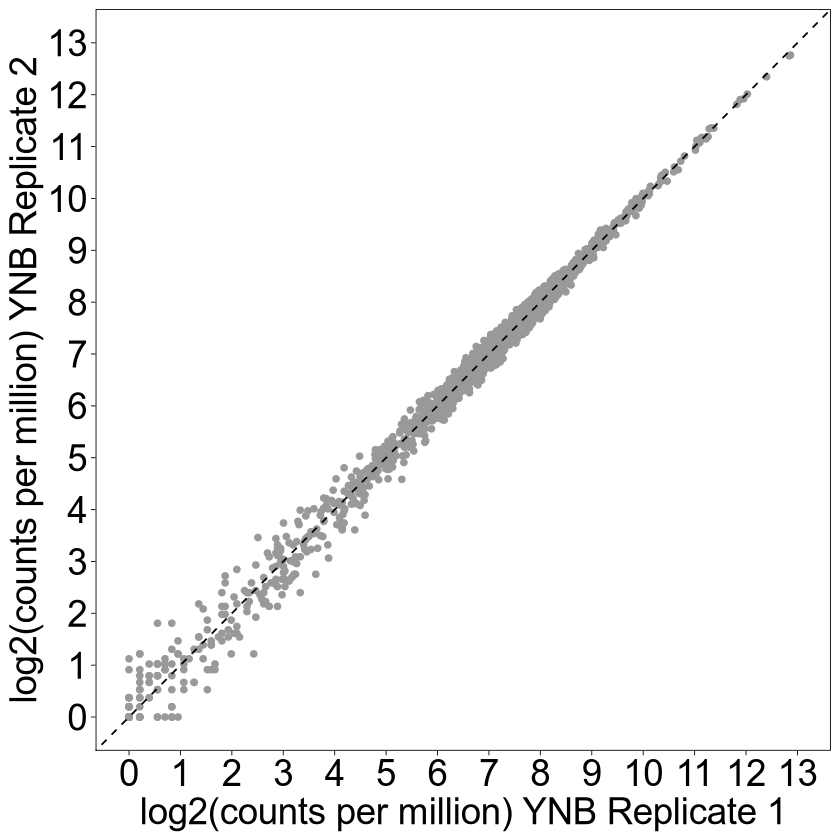

In [48]:
#Fig 1B

cor(log2norm_counts_df$Exp1_YNB_30C_1, log2norm_counts_df$Exp1_YNB_30C_2, method = 'pearson')

log2norm_counts_df %>% ggplot(aes(Exp1_YNB_30C_1, Exp1_YNB_30C_2)) + geom_point(color = 'grey60') +
                scale_x_continuous(breaks = seq(0,13,1), limits = c(0,13)) +
                scale_y_continuous(breaks = seq(0,13,1), limits = c(0,13)) +
                theme_linedraw() +
                geom_abline(intercept = 0, slope = 1, linetype = 'dashed') +
                theme(text = element_text(family = 'Arial'),
                      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                axis.text = element_text(size = 22), axis.title = element_text(size = 22)) +
                labs(x = 'log2(counts per million) YNB Replicate 1', y = 'log2(counts per million) YNB Replicate 2')

Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”


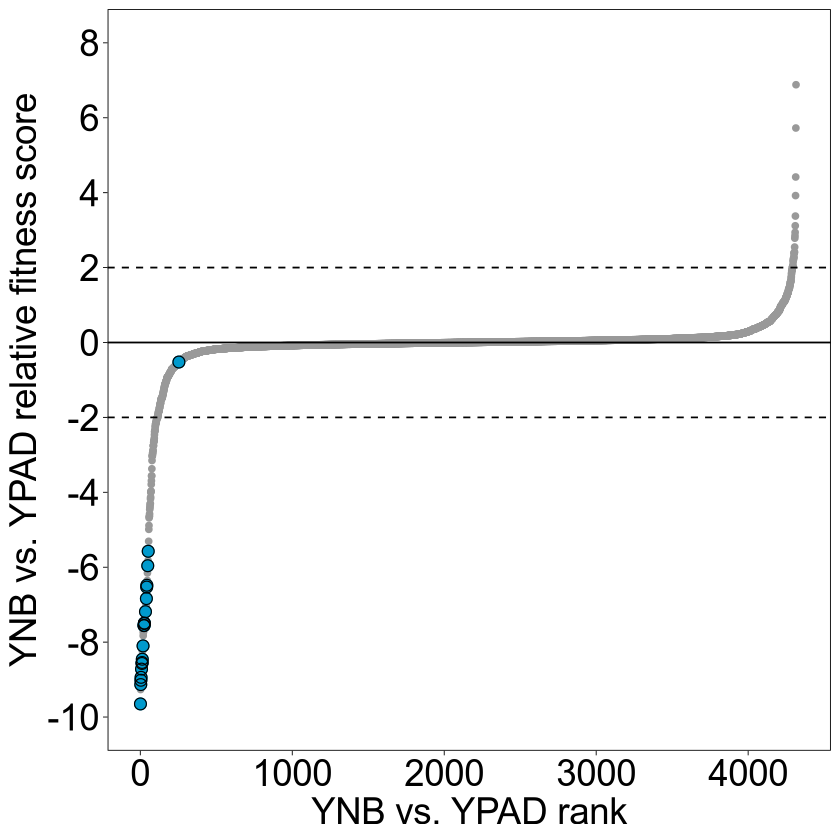

In [49]:
#Fig 1C

ChemGenetics_DESeq_df %>% mutate(highlight = ifelse(Gene %in% c('CNAG_02853', 'CNAG_06314', 'CNAG_02795', 'CNAG_04215', 'CNAG_03898',
                                                                'CNAG_05898', 'CNAG_05070', 'CNAG_03168', 'CNAG_02270', 'CNAG_00760',
                                                                'CNAG_02826', 'CNAG_01238', 'CNAG_00622', 'CNAG_02812', 'CNAG_02825',
                                                                'CNAG_06112', 'CNAG_00734', 'CNAG_07373', 'CNAG_04990', 'CNAG_05899'),
                                                    1, 0)) %>%
                arrange(highlight) %>%
                ggplot(aes(Exp1_YNBvsYPAD_30C_DESeq_L2FC_scaled_rank, Exp1_YNBvsYPAD_30C_DESeq_L2FC_scaled, color = as.factor(highlight), size = as.factor(highlight))) +
                geom_point() +
                scale_size_manual(values = c(1.5,3)) +
                scale_color_manual(values = c('grey60', 'deepskyblue3')) +
                scale_y_continuous(breaks = seq(-10,8,2), limits = c(-10,8)) +
                geom_point(data = ~filter(.x, highlight == 1), size = 3, shape = 1, color = 'black') +                
                theme_linedraw() +
                geom_hline(yintercept = 0) +
                geom_hline(yintercept = -2, linetype = 'dashed') +
                geom_hline(yintercept = 2, linetype = 'dashed') +
                theme(text = element_text(family = 'Arial'),
                      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                      axis.text = element_text(size = 22), axis.title = element_text(size = 22),
                      legend.position = 'none') +
                labs(x = 'YNB vs. YPAD rank', y = 'YNB vs. YPAD relative fitness score')

#CNAG_02853 -- ADE4
#CNAG_06314 -- ADE57
#CNAG_02795 -- ADE8
#CNAG_04215 -- MET3
#CNAG_03898 -- MET16
#CNAG_05898 -- MET8
#CNAG_05070 -- MET5
#CNAG_03168 -- MET10
#CNAG_02270 -- MET2
#CNAG_00760 -- MET12
#CNAG_02826 -- ARG2
#CNAG_01238 -- ARG7
#CNAG_00622 -- ARG8
#CNAG_02812 -- ARG3
#CNAG_02825 -- ARG4
#CNAG_06112 -- CPA2
#CNAG_00734 -- URA4
#CNAG_07373 -- URA2
#CNAG_04990 -- PRO2
#CNAG_05899 -- PRO3

Warning message:
“Removed 17 rows containing missing values (`geom_point()`).”


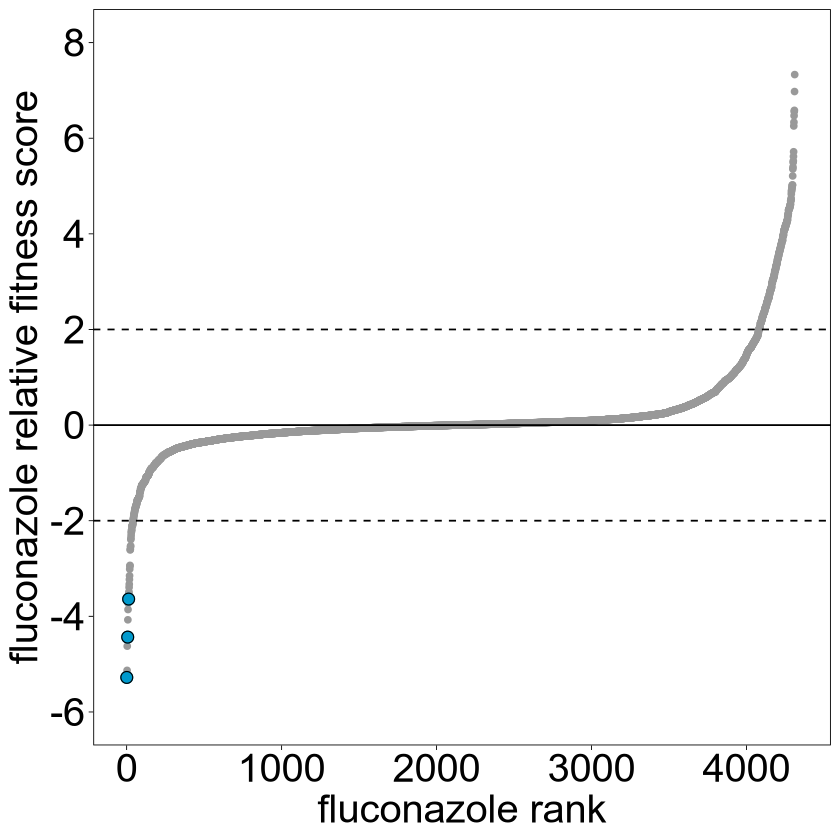

In [50]:
#Fig S1G

ChemGenetics_DESeq_df %>% mutate(highlight = ifelse(Gene %in% c('CNAG_01580', 'CNAG_04804', 'CNAG_05742'), 1, 0)) %>%
                arrange(highlight) %>%
                ggplot(aes(Exp4_Fluconazole_3ugml_DESeq_L2FC_scaled_rank, Exp4_Fluconazole_3ugml_DESeq_L2FC_scaled, color = as.factor(highlight), size = as.factor(highlight))) +
                geom_point() +
                scale_size_manual(values = c(1.5,3)) +
                scale_color_manual(values = c('grey60', 'deepskyblue3')) +
                scale_y_continuous(breaks = seq(-6,8,2), limits = c(-6,8)) +
                geom_point(data = ~filter(.x, highlight == 1), size = 3, shape = 1, color = 'black') +                
                theme_linedraw() +
                geom_hline(yintercept = 0) +
                geom_hline(yintercept = -2, linetype = 'dashed') +
                geom_hline(yintercept = 2, linetype = 'dashed') +
                theme(text = element_text(family = 'Arial'),
                      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                      axis.text = element_text(size = 24), axis.title = element_text(size = 24),
                      legend.position = 'none') +
                labs(x = 'fluconazole rank', y = 'fluconazole relative fitness score')


#CNAG_01580 -- SCP1
#CNAG_04804 -- SRE1
#CNAG_05742 -- STP1

Warning message:
“Removed 17 rows containing missing values (`geom_point()`).”


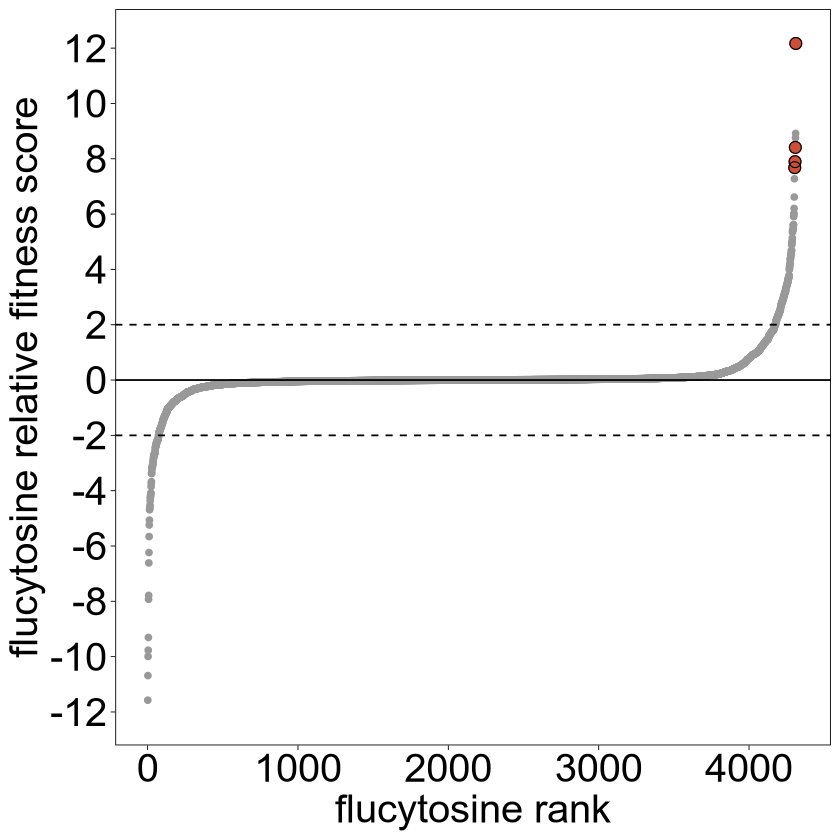

In [51]:
#Fig S1B

ChemGenetics_DESeq_df %>% mutate(highlight = ifelse(Gene %in% c('CNAG_00613', 'CNAG_01681', 'CNAG_02337', 'CNAG_03322'), 1, 0)) %>%
                arrange(highlight) %>%
                ggplot(aes(Exp4_Flucytosine_40ngml_DESeq_L2FC_scaled_rank, Exp4_Flucytosine_40ngml_DESeq_L2FC_scaled, color = as.factor(highlight), size = as.factor(highlight))) +
                geom_point() +
                scale_size_manual(values = c(1.5,3)) +
                scale_color_manual(values = c('grey60', 'tomato3')) +
                scale_y_continuous(breaks = seq(-12,12,2), limits = c(-12,12.2)) +
                geom_point(data = ~filter(.x, highlight == 1), size = 3, shape = 1, color = 'black') +                
                theme_linedraw() +
                geom_hline(yintercept = 0) +
                geom_hline(yintercept = -2, linetype = 'dashed') +
                geom_hline(yintercept = 2, linetype = 'dashed') +
                theme(text = element_text(family = 'Arial'),
                      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                      axis.text = element_text(size = 24), axis.title = element_text(size = 24),
                      legend.position = 'none') +
                labs(x = 'flucytosine rank', y = 'flucytosine relative fitness score')


#CNAG_00613 = FCY1
#CNAG_01681 = FCY2
#CNAG_02337 = FUR1
#CNAG_03322 = UXS1

Warning message:
“Removed 20 rows containing missing values (`geom_point()`).”


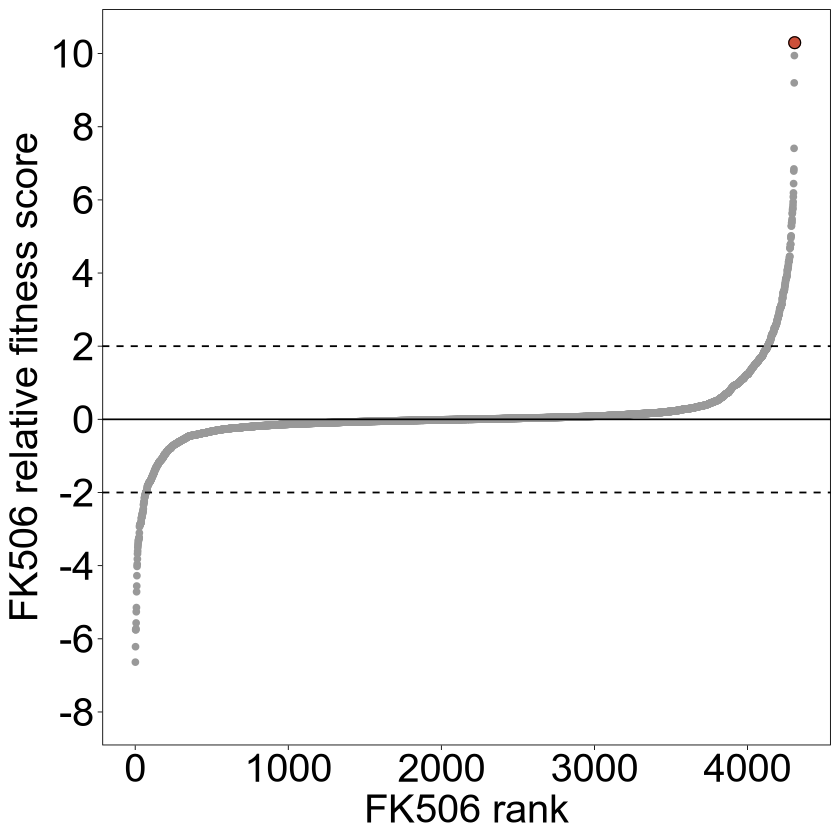

In [52]:
#Fig S1C

ChemGenetics_DESeq_df %>% mutate(highlight = ifelse(Gene %in% c('CNAG_03682'), 1, 0)) %>%
                arrange(highlight) %>%
                ggplot(aes(Exp10_FK506_5ngml_DESeq_L2FC_scaled_rank, Exp10_FK506_5ngml_DESeq_L2FC_scaled, color = as.factor(highlight), size = as.factor(highlight))) +
                geom_point() +
                scale_size_manual(values = c(1.5,3)) +
                scale_color_manual(values = c('grey60', 'tomato3')) +
                scale_y_continuous(breaks = seq(-8,10,2), limits = c(-8,10.3)) +
                geom_point(data = ~filter(.x, highlight == 1), size = 3, shape = 1, color = 'black') +                
                theme_linedraw() +
                geom_hline(yintercept = 0) +
                geom_hline(yintercept = -2, linetype = 'dashed') +
                geom_hline(yintercept = 2, linetype = 'dashed') +
                theme(text = element_text(family = 'Arial'),
                      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                      axis.text = element_text(size = 24), axis.title = element_text(size = 24),
                      legend.position = 'none') +
                labs(x = 'FK506 rank', y = 'FK506 relative fitness score')

#CNAG_03682 = FRR1

Warning message:
“Removed 12 rows containing missing values (`geom_point()`).”


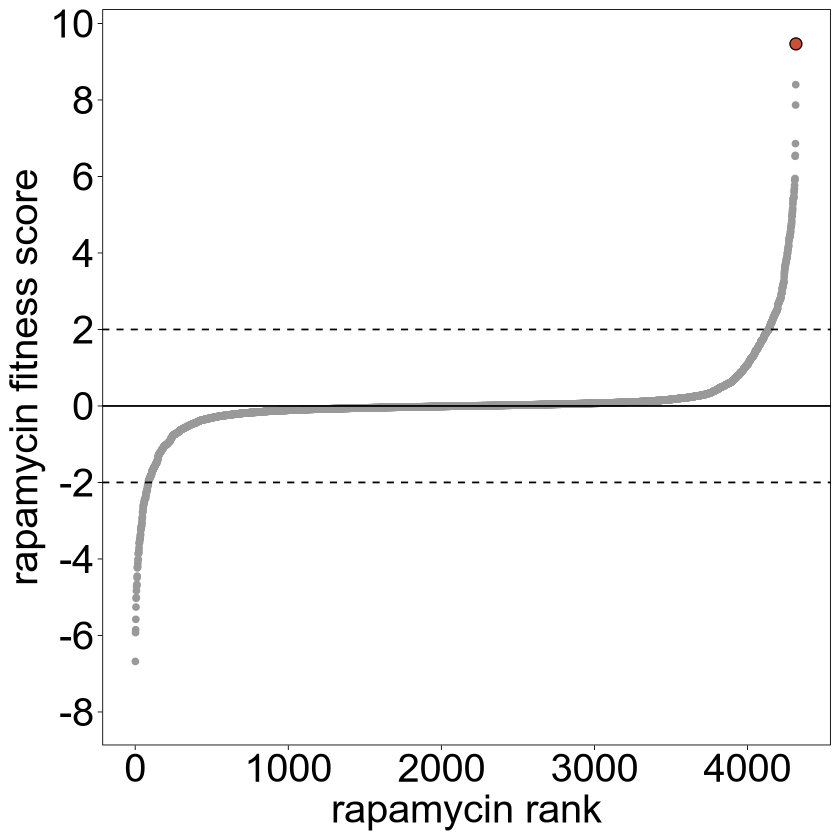

In [53]:
#Fig S1D

ChemGenetics_DESeq_df %>% mutate(highlight = ifelse(Gene %in% c('CNAG_03682'), 1, 0)) %>%
                arrange(highlight) %>%
                ggplot(aes(Exp17_Rapamycin_1250pgml_DESeq_L2FC_scaled_rank, Exp17_Rapamycin_1250pgml_DESeq_L2FC_scaled, color = as.factor(highlight), size = as.factor(highlight))) +
                geom_point() +
                scale_size_manual(values = c(1.5,3)) +
                scale_color_manual(values = c('grey60', 'tomato3')) +
                scale_y_continuous(breaks = seq(-8,10,2), limits = c(-8,9.5)) +
                geom_point(data = ~filter(.x, highlight == 1), size = 3, shape = 1, color = 'black') +                
                theme_linedraw() +
                geom_hline(yintercept = 0) +
                geom_hline(yintercept = -2, linetype = 'dashed') +
                geom_hline(yintercept = 2, linetype = 'dashed') +
                theme(text = element_text(family = 'Arial'),
                      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                      axis.text = element_text(size = 24), axis.title = element_text(size = 24),
                      legend.position = 'none') +
                labs(x = 'rapamycin rank', y = 'rapamycin fitness score')



#CNAG_03682 = FRR1

Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


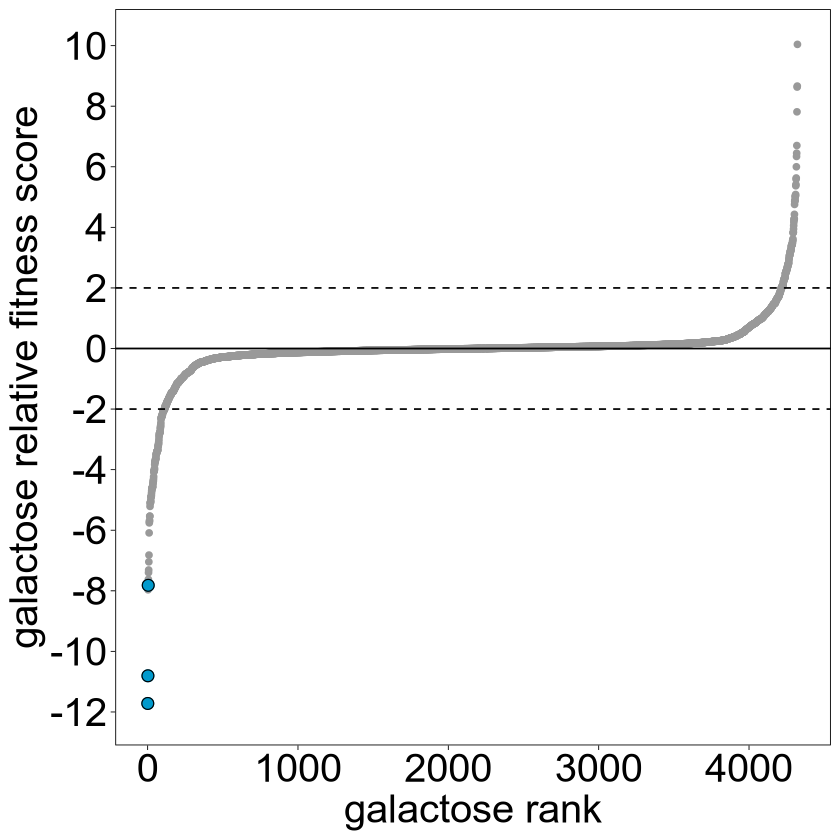

In [54]:
#Fig S1E

ChemGenetics_DESeq_df %>% mutate(highlight = ifelse(Gene %in% c('CNAG_06052', 'CNAG_06050', 'CNAG_06051'), 1, 0)) %>%
                arrange(highlight) %>%
                ggplot(aes(Exp18_Galactose_Alt_DESeq_L2FC_scaled_rank, Exp18_Galactose_Alt_DESeq_L2FC_scaled, color = as.factor(highlight), size = as.factor(highlight))) +
                geom_point() +
                scale_size_manual(values = c(1.5,3)) +
                scale_color_manual(values = c('grey60', 'deepskyblue3')) +
                scale_y_continuous(breaks = seq(-12,10,2), limits = c(-12,10.1)) +
                geom_point(data = ~filter(.x, highlight == 1), size = 3, shape = 1, color = 'black') +                
                theme_linedraw() +
                geom_hline(yintercept = 0) +
                geom_hline(yintercept = -2, linetype = 'dashed') +
                geom_hline(yintercept = 2, linetype = 'dashed') +
                theme(text = element_text(family = 'Arial'),
                      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                      axis.text = element_text(size = 24), axis.title = element_text(size = 24),
                      legend.position = 'none') +
                labs(x = 'galactose rank', y = 'galactose relative fitness score')



#CNAG_06052 = GAL7
#CNAG_06050 = UGE2
#CNAG_06051 = GAL1

Warning message:
“Removed 22 rows containing missing values (`geom_point()`).”


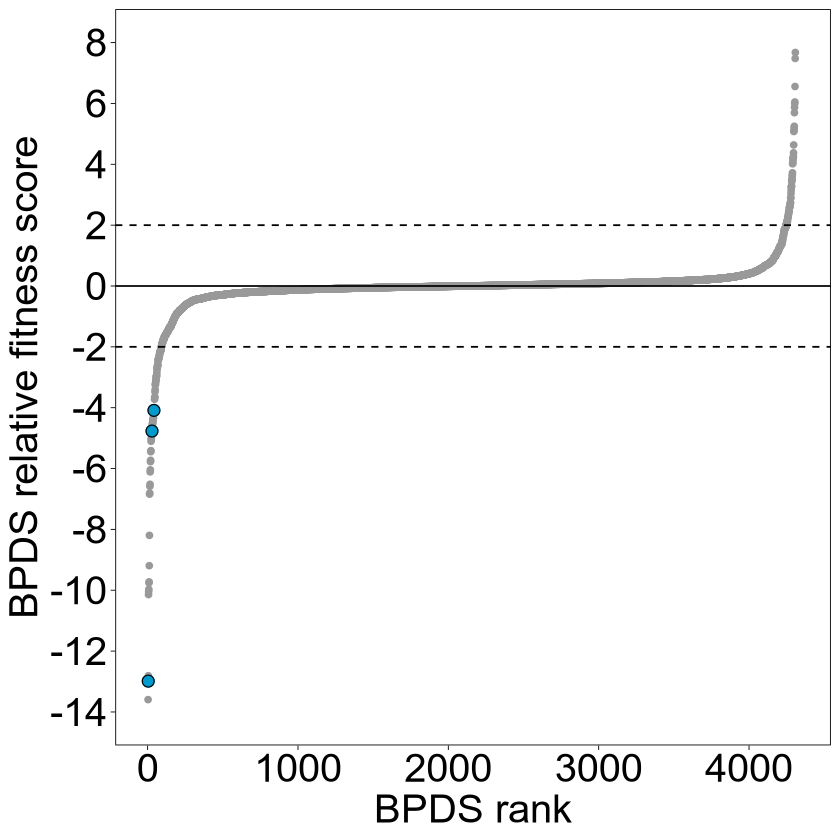

In [55]:
#Fig S1F

ChemGenetics_DESeq_df %>% mutate(highlight = ifelse(Gene %in% c('CNAG_01242', 'CNAG_07680', 'CNAG_02215'), 1, 0)) %>%
                arrange(highlight) %>%
                ggplot(aes(Exp22_BPS_15uM_DESeq_L2FC_scaled_rank, Exp22_BPS_15uM_DESeq_L2FC_scaled, color = as.factor(highlight), size = as.factor(highlight))) +
                geom_point() +
                scale_size_manual(values = c(1.5,3)) +
                scale_color_manual(values = c('grey60', 'deepskyblue3')) +
                scale_y_continuous(breaks = seq(-14,8,2), limits = c(-14,8)) +
                geom_point(data = ~filter(.x, highlight == 1), size = 3, shape = 1, color = 'black') +                
                theme_linedraw() +
                geom_hline(yintercept = 0) +
                geom_hline(yintercept = -2, linetype = 'dashed') +
                geom_hline(yintercept = 2, linetype = 'dashed') +
                theme(text = element_text(family = 'Arial'),
                      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                      axis.text = element_text(size = 24), axis.title = element_text(size = 24),
                      legend.position = 'none') +
                labs(x = 'BPDS rank', y = 'BPDS relative fitness score')


#CNAG_02215 = HAP3
#CNAG_07680 = HAP5
#CNAG_01242 = HAPX

In [56]:
#Rank mutants by mouse fitness
mouse_fitness_df <- mouse_fitness_df %>% mutate(MouseRank = rank(Mouse_Fitness))

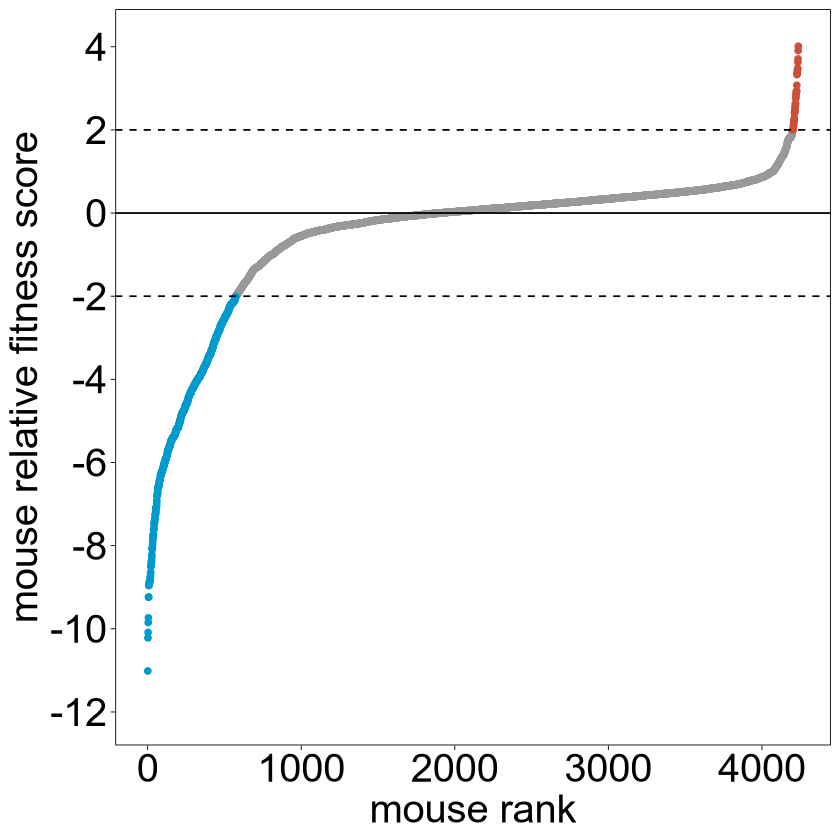

In [57]:
#Fig 4B

mouse_fitness_df %>% mutate(highlight = case_when(MouseEnriched == 1 ~ 'enriched',
                                                  MouseAttenuated == 1 ~ 'depleted',
                                                  TRUE ~ 'a')) %>%
                arrange(highlight) %>%
                ggplot(aes(MouseRank, Mouse_Fitness, color = highlight)) +
                geom_point() +
                scale_size_manual(values = c('a' = 3, 'enriched' = 3, 'depleted' = 3)) +
                scale_color_manual(values = c('a' = 'gray60', 'enriched' = 'tomato3', 'depleted' = 'deepskyblue3')) +
                scale_y_continuous(breaks = seq(-12,4,2), limits = c(-12,4.1)) +
                theme_linedraw() +
                geom_hline(yintercept = 0) +
                geom_hline(yintercept = -2, linetype = 'dashed') +
                geom_hline(yintercept = 2, linetype = 'dashed') +
                theme(text = element_text(family = 'Arial'),
                      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                      axis.text = element_text(size = 24), axis.title = element_text(size = 24),
                      legend.position = 'none') +
                labs(x = 'mouse rank', y = 'mouse relative fitness score')